# Demo: MNIST Digit Classification with Pytorch

## Import Libraries

In [ ]:
# Demo: MNIST Digit Classification with Pytorch
import numpy as np
import matplotlib.pyplot as plt

# PyTorch libraries
import torch                                          # PyTorch main library
import torch.nn as nn                                 # Neural network module
import torch.optim as optim                           # Optimization algorithms
from torch.utils.data import DataLoader               # Data loading utilities
from torchvision import datasets, transforms          # Datasets and transformations
from torchinfo import summary                             # Model summary utility

In [2]:
def set_seed(seed):
    """Set the random seed for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    # manual seed for apple silicon macs
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed) # For Apple Silicon Macs

set_seed(42)

## Load MNIST Dataset

Laden der MNIST-Daten mit Normalisierung unterteilt in Trainings- und Testdatensätze.

```python

In [3]:
# Data transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                             transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True,
                            transform=transform)

Darstellung der Formate der Trainingsdaten und -labels.

In [4]:
print(f'Training set shape: {mnist_train.data.shape}, {mnist_train.targets.shape}')

print(f'Test set shape: {mnist_test.data.shape}, {mnist_test.targets.shape}')

Training set shape: torch.Size([60000, 28, 28]), torch.Size([60000])
Test set shape: torch.Size([10000, 28, 28]), torch.Size([10000])


### Visualisierung einiger Beispielbilder aus dem Trainingsdatensatz mit ihren entsprechenden Labels.

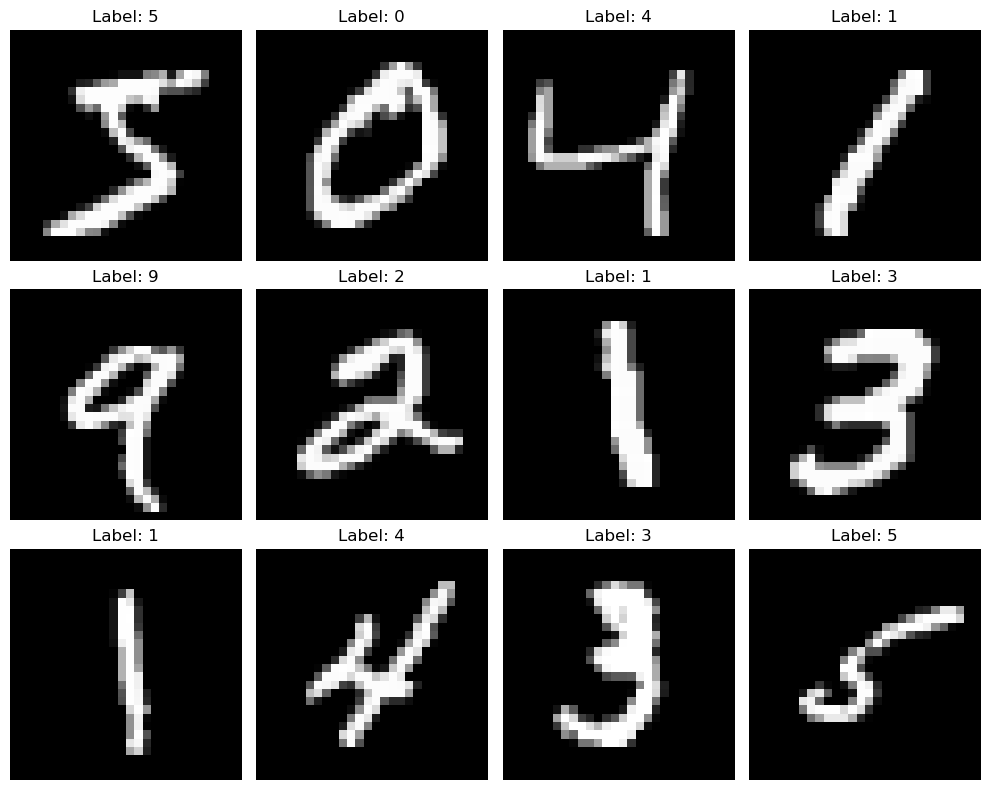

In [5]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(mnist_train.data[i], cmap='gray')
    plt.title(f'Label: {mnist_train.targets[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model Architecture and Training

### Model Definition

In [6]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling Layer 1
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv Layer 2
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),                 # Pooling Layer 2
    nn.Flatten(),                                          # Flatten Layer
    nn.Linear(64 * 7 * 7, 128),                            # Fully Connected Layer 1
    nn.ReLU(),
    nn.Linear(128, 10)                                     # Output Layer
)

# summary of the model
print(summary(model, input_size=(1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           18,496
├─ReLU: 1-5                              [1, 64, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 128]                  401,536
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.28
Input size (MB): 0.00
Forward/

### Training configuration

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   
batch_size = 64
num_epochs = 10
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"


### Functions for Model Training and Validation

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

def train(model, device, train_loader, optimizer, criterion):
    # set model to training mode
    model.train()
    # move model to device
    model.to(device)

    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # iterate over batches
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Compute average loss and accuracy
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct_predictions / total_samples

    return avg_loss, accuracy


## Prepare test data loader
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# Validation function
def validation(model, device, test_loader, criterion):
    model.eval()
    model.to(device)
    # Initialize running loss and correct predictions
    running_loss = 0            # Initialize running loss
    correct_predictions = 0     # Initialize correct predictions
    total_samples = 0           # Initialize total samples
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    #calculate average loss and accuracy
    test_loss = running_loss / len(test_loader)
    accuracy = 100. * correct_predictions / total_samples

    return test_loss, accuracy


# Main training loop
def main(model, train_loader, test_loader, device, num_epochs):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # train the model for one epoch
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        
        # validate the model for one epoch
        val_loss, val_accuracy = validation(model, device, test_loader, criterion)

        # Save losses and accuracies for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # print progress
        print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

### Executation of Training and Validation Loop

In [13]:
train_losses, val_losses, train_accuracies, val_accuracies = main(model, train_loader, test_loader, device=DEVICE, num_epochs=num_epochs)

Epoch 1/10: Train Loss: 0.0059, Train Accuracy: 99.80% - Val Loss: 0.0006, Val Accuracy: 99.17%
Epoch 2/10: Train Loss: 0.0063, Train Accuracy: 99.76% - Val Loss: 0.0005, Val Accuracy: 99.22%
Epoch 3/10: Train Loss: 0.0032, Train Accuracy: 99.91% - Val Loss: 0.0005, Val Accuracy: 99.22%
Epoch 4/10: Train Loss: 0.0053, Train Accuracy: 99.82% - Val Loss: 0.0006, Val Accuracy: 99.05%
Epoch 5/10: Train Loss: 0.0041, Train Accuracy: 99.86% - Val Loss: 0.0007, Val Accuracy: 99.03%
Epoch 6/10: Train Loss: 0.0041, Train Accuracy: 99.86% - Val Loss: 0.0005, Val Accuracy: 99.22%
Epoch 7/10: Train Loss: 0.0043, Train Accuracy: 99.85% - Val Loss: 0.0006, Val Accuracy: 99.09%
Epoch 8/10: Train Loss: 0.0029, Train Accuracy: 99.91% - Val Loss: 0.0010, Val Accuracy: 98.97%
Epoch 9/10: Train Loss: 0.0026, Train Accuracy: 99.92% - Val Loss: 0.0009, Val Accuracy: 98.78%
Epoch 10/10: Train Loss: 0.0061, Train Accuracy: 99.82% - Val Loss: 0.0008, Val Accuracy: 99.12%


### Visualization of Training Progress

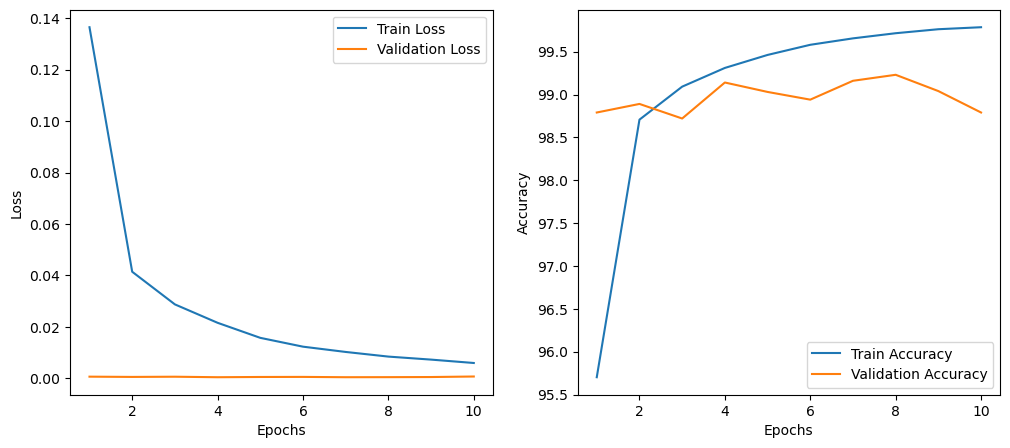

In [10]:
# Plotting loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model Evaluation

### Inference on Test Data

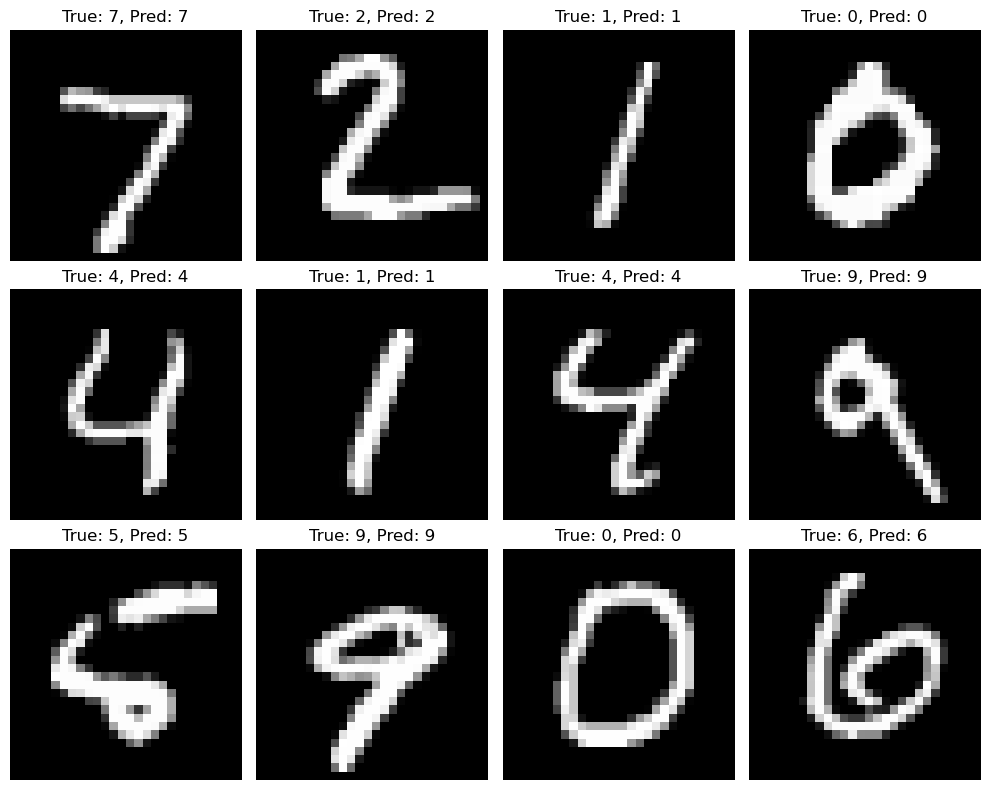

In [11]:
images, labels = next(iter(test_loader))
images, labels = images.to(DEVICE), labels.to(DEVICE)

with torch.no_grad():
    output = model(images)
    _, preds = torch.max(output, 1)
    
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Confusion Matrix Visualization

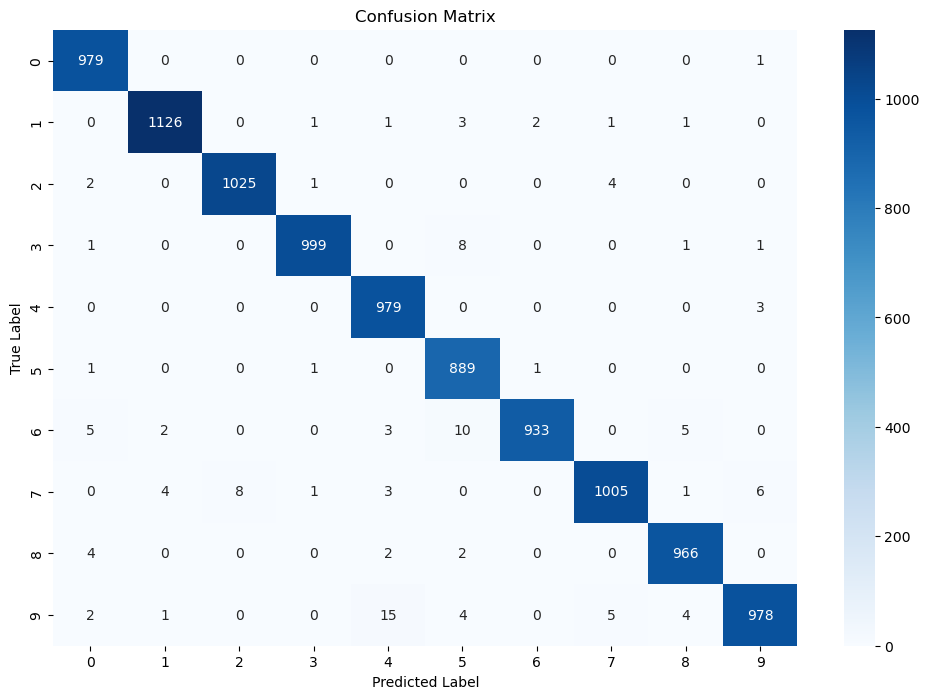

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for the entire test set
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        output = model(images)
        _, preds = torch.max(output, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
confusion_mtx = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10))) #type: ignore
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
